In [351]:
%matplotlib inline

In [352]:
import numpy as np
import jack_to_deal_auction as jack
import bidding
from data_access import card_index_lookup
import matplotlib.pyplot as plt

In [143]:
suit_index_lookup = {'S': 0, 'H': 1, 'D': 2, 'C': 3}

In [3]:
sample_str = '''W:AT73.JT4.92.A984 K4.AK76.KQT85.T2 QJ9865.Q53.64.65 2.982.AJ73.KQJ73
W ALL 3N.-1.N
PP 1N PP 3N PP PP PP
SQS2SAS4S3SKS5H2D5D4DJD2H9H4HAH3DTD6D3D9D8S6D7HTDQC5DAC4CKCAC2C6STH6S8C3S7H7S9C7SJH8C8CTHQCJHJHKDKH5CQC9
 SQ 5
 SJ 5
 S9 5
 S8 5
 S6 5
 S5 5
 HQ 2
 H5 2
 H3 2
 D6 2
 D4 2
 C6 2
 C5 2'''

In [20]:
bidding.encode_bid('1C').shape

(1, 40)

In [23]:
-1 % 4

3

In [21]:
def convert_auction(auction_str):
    return auction_str.strip().replace('PP', 'PASS').replace('DD', 'X').replace('RR', 'XX').split()

In [24]:
seats = ['W', 'N', 'E', 'S']
seat_index = {'W': 0, 'N': 1, 'E': 2, 'S': 3}

In [218]:
class DealMeta():
    
    def __init__(self, dealer, vuln, level, strain, doubled, redoubled, declarer, tricks_made):
        self.dealer = dealer
        self.vuln = vuln
        self.level = level
        self.strain = strain
        self.doubled = doubled
        self.redoubled = redoubled
        self.declarer = declarer
        self.tricks_made = tricks_made
        
    @classmethod
    def from_str(cls, s):
        #W ALL 3N.-1.N
        parts = s.strip().split()
        outcome = parts[2]
        outcome_parts = outcome.split('.')
        level = int(outcome_parts[0][0])
        doubled = 'X' in outcome_parts[0]
        redoubled = 'XX' in outcome_parts[0]
        strain = outcome_parts[0][1]
        tricks_made = (level + 6) if outcome_parts[1] == '=' else (level + 6) + int(outcome_parts[1])
        declarer = outcome_parts[2]
        
        return cls(
            dealer=parts[0],
            vuln=parts[1],
            level=level,
            strain=strain,
            doubled=doubled,
            redoubled=redoubled,
            declarer=declarer,
            tricks_made=tricks_made
        )
        
    def leader(self):
        return seats[(seat_index[self.declarer] + 1) % 4]
    
    def dealer_relative(self):
        return (seat_index[self.dealer] - seat_index[self.leader()]) % 4
    
    def declarer_vuln(self):
        if self.vuln == 'ALL':
            return True
        if self.vuln == '-':
            return False
        return self.declarer in self.vuln
    
    def leader_vuln(self):
        if self.vuln == 'ALL':
            return True
        if self.vuln == '-':
            return False
        return self.leader() in self.vuln
    
    def get_n_pad_start(self):
        dealer_ix = seat_index[self.dealer]
        declarer_ix = seat_index[self.declarer]
        
        return (dealer_ix - declarer_ix) % 4
    
    def to_dict(self):
        return {
            'dealer': self.dealer,
            'vuln': self.vuln,
            'level': self.level,
            'strain': self.strain,
            'doubled': self.doubled,
            'decarer': self.declarer,
            'tricks_made': self.tricks_made,
            'leader': self.leader(),
            'declarer_vuln': self.declarer_vuln(),
            'leader_vuln': self.leader_vuln()
        }
    

In [57]:
meta_str = 'W ALL 3N.-1.N'
d = DealMeta.from_str(meta_str)
d.to_dict(), d.get_n_pad_start()

({'dealer': 'W',
  'decarer': 'N',
  'declarer_vuln': True,
  'doubled': False,
  'leader': 'E',
  'leader_vuln': True,
  'level': 3,
  'strain': 'N',
  'tricks_made': 8,
  'vuln': 'ALL'},
 3)

In [118]:
np.float16

numpy.float16

In [141]:
def binary_hand(suits):
    x = np.zeros((1, 52), np.float16)
    assert(len(suits) == 4)
    for suit_index in [0, 1, 2, 3]:
        for card in suits[suit_index]:
            card_index = card_index_lookup[card]
            x[0, suit_index * 13 + card_index] = 1
    assert(np.sum(x) == 13)
    return x

In [194]:
def loss_array(card_tricks, max_loss=40):
    assert(len(card_tricks) == 13)
    x = max_loss * np.ones((1, 52), np.float16)
    max_tricks = max(card_tricks.values())
    for card, tricks in card_tricks.items():
        loss = max_tricks - tricks
        suit_index = suit_index_lookup[card[0]]
        card_index = card_index_lookup[card[1]]
        x[0, suit_index * 13 + card_index] = loss
    
    assert(np.sum(x < max_loss) == 13)
    
    return x

In [333]:
def lead_data_iterator(fin):
    lines = []
    for i, line in enumerate(fin):
        line = line.strip()
        if i % 17 == 0 and i > 0:
            deal_str = lines[0]
            hands = list(map(lambda hand_str: list(map(list, hand_str.split('.'))), deal_str[2:].split()))
            deal_meta = DealMeta.from_str(lines[1])
            # auction
            padded_auction = (['PAD_START'] * deal_meta.get_n_pad_start()) + convert_auction(lines[2])
            n_pad_end = 4 - (len(padded_auction) % 4) if (len(padded_auction) % 4) > 0 else 0
            padded_auction = padded_auction + (['PAD_END'] * n_pad_end)
            padded_auction = padded_auction[:-4] if set(padded_auction[-4:]) == set(['PASS', 'PAD_END']) else padded_auction
            # lead_tricks
            lead_tricks = {}
            for card_tricks_line in lines[4:]:
                card, tricks = card_tricks_line.strip().split()
                lead_tricks[card] = int(tricks)
                
            led_card = lines[3][:2]
            max_tricks = max(lead_tricks.values())
            
            yield max_tricks - lead_tricks[led_card]   
            #yield lines, hands, deal_meta, padded_auction, lead_tricks
            
            lines = []
        
        lines.append(line)

In [129]:
list(map(list, 'Q962.AT7.632.K84'.split('.')))

[['Q', '9', '6', '2'], ['A', 'T', '7'], ['6', '3', '2'], ['K', '8', '4']]

In [142]:
binary_hand(list(map(list, 'J5.K863.KT76532.'.split('.'))))

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float16)

In [136]:
(np.sum(binary_hand(list(map(list, 'A73.QJ53.AQJ8.QJ'.split('.')))).reshape((4, 13)), axis=1) - 3.25) / 1.75

array([-0.14282227,  0.4284668 ,  0.4284668 , -0.71435547], dtype=float16)

In [195]:
loss_array({'CA': 5,
  'CJ': 3,
  'CQ': 3,
  'CT': 3,
  'D4': 5,
  'D7': 5,
  'DA': 4,
  'DJ': 5,
  'H5': 5,
  'S8': 4,
  'SJ': 4,
  'SQ': 4,
  'ST': 4}, 8)

array([[ 8.,  8.,  1.,  1.,  1.,  8.,  1.,  8.,  8.,  8.,  8.,  8.,  8.,
         8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  0.,  8.,  8.,  8.,
         1.,  8.,  8.,  0.,  8.,  8.,  8.,  0.,  8.,  8.,  0.,  8.,  8.,
         0.,  8.,  2.,  2.,  2.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.]], dtype=float16)

In [347]:
lead_it = lead_data_iterator(open('../data/leads_raw/BW5C_N.txt'))

In [348]:
losses_nt = [l for l in lead_it]

In [344]:
losses = [l for l in lead_it]

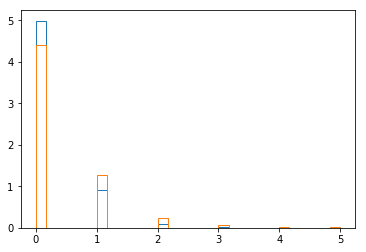

In [356]:
plt.hist(losses, 30, range=(0, 5), histtype='step', normed=True)
plt.hist(losses_nt, 30, range=(0, 5), histtype='step', normed=True);

In [350]:
np.mean(losses), np.mean(losses_nt), np.mean(losses + losses_nt)

(0.18427085975145829, 0.34879138897704431, 0.22988261344556299)

In [178]:
next(lead_it)

(['W:KQJ952.98.AQ9.95 6.AQ6.T8765.AKJ3 T874.J73.K3.8742 A3.KT542.J42.QT6',
  'N - 4S.-2.W',
  '1D PP 1H 2S DD 3S 4D 4S PP PP PP',
  'CAC2C6C5CKC4CTC9D8D3DJDASJS6S4SAH2H8HQH3HAH7H4H9D6DKD2D9S8S3S2D5C8CQS5C3DQD7C7D4S9H6S7H5SKDTSTHTSQCJHJHK',
  'S6 5',
  'HA 5',
  'HQ 5',
  'H6 5',
  'DT 5',
  'D8 5',
  'D7 5',
  'D6 5',
  'D5 5',
  'CA 5',
  'CK 5',
  'CJ 5',
  'C3 5'],
 [[['K', 'Q', 'J', '9', '5', '2'], ['9', '8'], ['A', 'Q', '9'], ['9', '5']],
  [['6'], ['A', 'Q', '6'], ['T', '8', '7', '6', '5'], ['A', 'K', 'J', '3']],
  [['T', '8', '7', '4'], ['J', '7', '3'], ['K', '3'], ['8', '7', '4', '2']],
  [['A', '3'], ['K', 'T', '5', '4', '2'], ['J', '4', '2'], ['Q', 'T', '6']]],
 {'dealer': 'N',
  'decarer': 'W',
  'declarer_vuln': False,
  'doubled': False,
  'leader': 'N',
  'leader_vuln': False,
  'level': 4,
  'strain': 'S',
  'tricks_made': 8,
  'vuln': '-'},
 ['PAD_START',
  '1D',
  'PASS',
  '1H',
  '2S',
  'X',
  '3S',
  '4D',
  '4S',
  'PASS',
  'PASS',
  'PASS'],
 {'C3': 5,
  'CA': 5

In [157]:
bidding.encode_bid('PASS').shape

(1, 40)

In [158]:
X_bnn = np.load('./bw5c_bin/X_test.npy')

In [159]:
X_bnn.shape

(50000, 4, 179)

In [179]:
def binary_auction(auction, n_bids=24):
    assert(len(auction) % 4 == 0)
    auction = auction if len(auction) < n_bids else auction[(len(auction) - n_bids):]
    auction = (['PAD_START'] * (n_bids - len(auction))) + auction
    assert(len(auction) == n_bids)
    
    x = np.zeros((1, n_bids, 40), np.float16)
    
    for i, bid in enumerate(auction):
        x[0, i, :] = bidding.encode_bid(bid)
        
    assert(np.sum(x) == n_bids)
    
    return x

In [180]:
binauction = binary_auction(['PAD_START', '1C', 'X', 'PASS', '1H', 'X', '3H', 'PASS'])

In [181]:
binauction.shape

(1, 24, 40)

In [182]:
binauction[0, 16, :]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float16)

In [228]:
lines

['W:QJ84.K98.A952.T5 K.64.KQJ76.QJ973 AT97532.AT2.T8.K 6.QJ753.43.A8642',
 'E NS 4S.+1.E',
 '1S PP 3S PP 4S PP PP PP',
 'HQH8H4HASAS6S4SKCKCAC5C7D4D2DJD8CQS3C6CTH2H3H9H6HKC3HTH5DAD6DTD3D5D7S2C2S5C4S8C9D9DQS7H7STC8SJCJSQDKS9HJ',
 'S6 3',
 'HQ 2',
 'HJ 2',
 'H7 2',
 'H5 2',
 'H3 2',
 'D4 3',
 'D3 3',
 'CA 3',
 'C8 2',
 'C6 2',
 'C4 2',
 'C2 2']

In [229]:
hands

[[['Q', 'J', '8', '4'], ['K', '9', '8'], ['A', '9', '5', '2'], ['T', '5']],
 [['K'], ['6', '4'], ['K', 'Q', 'J', '7', '6'], ['Q', 'J', '9', '7', '3']],
 [['A', 'T', '9', '7', '5', '3', '2'], ['A', 'T', '2'], ['T', '8'], ['K']],
 [['6'], ['Q', 'J', '7', '5', '3'], ['4', '3'], ['A', '8', '6', '4', '2']]]

In [230]:
hand_features(hands, deal_meta)

array([[ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        , -1.28613281,
         1.        , -0.71435547,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0. 

### hand features encoding

shape = (1, 1 + 5 + 1 + 1 + 4 + 1 + 1 + 4 + 52) = (1, 70)

- 0 = encoded level (actual level - 3)
- 1,2,3,4,5 = strain one-hot (N, S, H, D, C)
- 6 = doubled
- 7 = redoubled
- 8, 9, 10, 11 = dealer id (0=leader, 1=dummy, 2=partner, 3=declarer)
- 12 = vuln leader
- 13 = vuln declarer
- 14, 15, 16, 17 = shape of hand (S, H, D, C)
- 18:70 = cards themselves one-hot encoded, 52 features with 13 set to 1

### Auction sequence encoding
shape = (n_examples=?, n_bids=24, 40). the last dimension is the bid one-hot encoding

In [201]:
def hand_features(hands, deal_meta):
    x = np.zeros((1, 70), np.float16)
    x[0, 0] = deal_meta.level - 3
    if deal_meta.strain == 'N':
        x[0, 1] = 1
    else:
        x[0, 2 + suit_index_lookup[deal_meta.strain]] = 1
    if deal_meta.doubled:
        x[0, 6] = 1
    if deal_meta.redoubled:
        x[0, 7] = 1
    x[0, 8 + deal_meta.dealer_relative()] = 1
    if deal_meta.leader_vuln():
        x[0, 12] = 1
    if deal_meta.declarer_vuln():
        x[0, 13] = 1
    h = binary_hand(hands[seat_index[deal_meta.leader()]])
    shape = (np.sum(h.reshape((4, 13)), axis=1) - 3.25) / 1.75
    x[0, 14:18] = shape
    x[0, 18:70] = h
    
    return x

### Prediction loss encoding

shape = (1, 52)

for every card there is a loss. cards that you don't have in your hand have a very large loss

In [172]:
1 + 5 + 1 + 1 + 4 + 1 + 1 + 4 + 52

70

### Trying if it works

In [232]:
A = np.load('../data/leads_bin/A.npy')
H = np.load('../data/leads_bin/H.npy')
C = np.load('../data/leads_bin/C.npy')

In [251]:
i = -1
lead_it = lead_data_iterator(open('../data/leads_raw/BW5C_N.txt'))

In [293]:
i += 1
lines, _, _, padded_auction, _ = next(lead_it)
i, lines, padded_auction

(1,
 ['W:A653.987.8752.74 942.T32.Q43.AKJ3 KQJ.KQ6.KJ6.QT98 T87.AJ54.AT9.652',
  'E EW 1N.-1.E',
  '1N PP PP PP',
  'H4H7HTHKSKS8S3S9SJS7S5S2SQSTSAS4S6H2C9C6C4CKC8C5H3HQHAH8HJH9D3H6H5D2C3D6C2C7CACTCJCQD9D5DJDTD7DQD4DKDAD8',
  'ST 7',
  'S8 7',
  'S7 7',
  'HA 6',
  'HJ 6',
  'H5 7',
  'H4 7',
  'DA 6',
  'DT 7',
  'D9 7',
  'C6 7',
  'C5 7',
  'C2 7'],
 ['1N', 'PASS', 'PASS', 'PASS'])

In [322]:
i = 1285625 // 17 - 1

In [323]:
recovered_auction = [bidding.ID2BID[np.argmax(A[i, k, :])] for k in range(24)]
recovered_auction[(24 - list(reversed(recovered_auction)).index('PAD_START')):]

['1C', 'PASS', '1S', 'PASS', '3C', 'PASS', '3N', 'PASS', 'PASS', 'PASS']

In [324]:
C[i].reshape(4, 13)

array([[ 40.,   1.,  40.,   2.,  40.,  40.,  40.,  40.,  40.,   1.,   1.,
         40.,   1.],
       [ 40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,   0.,  40.,  40.,
         40.,  40.],
       [ 40.,  40.,  40.,  40.,  40.,  40.,   0.,   0.,   0.,  40.,  40.,
         40.,  40.],
       [ 40.,  40.,  40.,   1.,   1.,  40.,  40.,  40.,  40.,   0.,  40.,
          0.,  40.]], dtype=float16)

In [325]:
H[i, 0]

0.0

In [326]:
H[i, 1:6]

array([ 1.,  0.,  0.,  0.,  0.], dtype=float16)

In [327]:
H[i, 6:8]

array([ 0.,  0.], dtype=float16)

In [328]:
H[i, 8:12]

array([ 0.,  1.,  0.,  0.], dtype=float16)

In [329]:
H[i, 12:14]

array([ 0.,  0.], dtype=float16)

In [330]:
H[i, 14:18]

array([ 1.        , -1.28613281, -0.14282227,  0.4284668 ], dtype=float16)

In [331]:
H[i, 18:]

array([ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.], dtype=float16)

In [332]:
H[i, 18:] * (C[i] + 1)

array([ 0.,  2.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  2.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.], dtype=float16)